# Federated learning: deep learning for vertically partitioned data 

In this notebook, we provide a simple example of how to perform a **vertical** federated learning experiment with the help of the Sherpa.ai Federated Learning framework. 
As opposed to the horizontal federated learning paradigm, in a vertical federated learning setting (see e.g. [Federated Machine Learning: Concept and Applications](https://arxiv.org/abs/1902.04885)) the different nodes possess the same samples, but different features. 
A practical example being that of a local on-line shop and an insurance company: both entities might have matching customers (samples), but the information (features) each entity possesses about the customers is of different nature. 
We are going to use a synthetic dataset and a neural network model.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

## The data
We use `sklearn` module for generating synthetic databases. 
Moreover, in order to simulate a vertically partitioned training data, we randomly split the features of the created dataset among the clients:

In [2]:
# Create dataset
n_features = 20
n_classes = 2
n_samples = 15000

x, y = make_classification(
    n_samples=n_samples, n_features=n_features, 
    n_redundant=0, n_repeated=0, n_classes=n_classes, 
    n_clusters_per_class=1, flip_y=0.1, class_sep=0.4, random_state=123)
x = pd.DataFrame(x)

x_train = x[:int(n_samples * 0.8)]
x_test = x[int(n_samples * 0.8):]
y_train = y[:int(n_samples * 0.8), ]
y_test = y[int(n_samples * 0.8):, ]

In [3]:
def split_data_general(x_train, x_test, m, seed=None):
    """
    Splits two dataframes with the same columns (and possibly different number of rows)
    into M dataframes along the columns.

    # Arguments:
        X_train: dataframe with the training features
        y_test: dataframe with the test features
        m: number of clients
        seed: reproducible results (optional)
    # Returns:
        X_train_client: dictionary where the key is the clientId and the value is a dataframe with the training features
        X_test_client: dictionary where the key is the clientId and the value is a dataframe with the test features
    """
    np.random.seed(seed)
    n = x_train.shape[1]  # total number of features
    features = np.arange(n)
    np.random.shuffle(features)
    index_client = np.sort(
        np.append(np.random.choice(np.arange(1, n), m - 1), [0, n]))  # index where the features are split

    features_client = {i: features[index_client[i]:index_client[i + 1]] for i in range(m)}
    x_train_client = {i: x_train[features_client[i]] for i in range(m)}
    x_test_client = {i: x_test[features_client[i]] for i in range(m)}

    return x_train_client, x_test_client

In [4]:
# Create a vertically split dataset: split the features among clients
M = 2  # number of clients
x_train_client, x_test_client = split_data_general(x_train, x_test, M, seed=11)
train_labels_client = {0:None, 1:None}
print("Private data client 0: ", x_train_client[0].shape)
print("Private data client 1: ", x_train_client[1].shape)

Private data client 0:  (12000, 18)
Private data client 1:  (12000, 2)


In [5]:
# Make federated data: 
from shfl.private.data import LabeledData
from shfl.private.federated_operation import FederatedData
from shfl.data_distribution.data_distribution import DataDistribution

class DataDistributionFromList():
    """
        Data (and labels) are already in a list-type, 
        where each entry contains data of one node
    """
    def __init__(self):
        pass
    
    def get_data_federated(self, federated_train_data, federated_train_label):
        federated_data = FederatedData()
        num_nodes = len(federated_train_label)
        for node in range(num_nodes):
            node_data = LabeledData(federated_train_data[node], federated_train_label[node])
            federated_data.add_data_node(node_data)

        return federated_data
    
data_distribution = DataDistributionFromList()
federated_data = data_distribution.get_data_federated(x_train_client, train_labels_client)

In [6]:
# Federated data operation: need to transpose
from shfl.private import FederatedTransformation
from shfl.private.federated_operation import apply_federated_transformation

class Transpose(FederatedTransformation):
    
    def apply(self, labeled_data):
        if labeled_data.data is not None:
            labeled_data.data = labeled_data.data.T
        
apply_federated_transformation(federated_data, Transpose())
#federated_data[0].query().data

In [7]:
# Check federated data:
from shfl.private.data import UnprotectedAccess

federated_data.configure_data_access(UnprotectedAccess())
federated_data[0].query()
#federated_data[0].query().label

The interpretation of the Federated Government is proposed to change as follows: 
 - The Federated Government "self" is intended as a *Coordinator*: it schedules the federated computations, but does not have any other function (no data, no model)
 - The Federated Data is composed by nodes that can have multiple functions: train, store data, aggregate, make auxiliary computations, predictions
 - In particular, the Server is itself a *node* of the Federated Data: it might aggregate, but might also contain data and train on them
 
Note that in this perspective, each node is assigned a potentially *different model*. 
For example in Horizontal FL, all nodes have the same model, and the server node has also the aggregation function in its model as an attribute but do not train and does not possess any data.
Instead in Vertical FL the client nodes have a different model with respect the server node, which in turn can aggregate, train and possess its own data.

In addition, note that the distinction between client and server is *only virtual* and not necessarily physical, since a single node might be both client and server, allowing multiple roles for the same physical node.  

## Linear model:
First we compute a benchmark on centralized data using `sk-learn`:

In [8]:
def plot_roc(y_test, y_prediction, save_path=None):
    fpr, tpr, _ = roc_curve(y_test, y_prediction)
    roc_auc = auc(fpr, tpr)
    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(8, 7))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    if save_path is not None: 
        plt.savefig(save_path, bbox_inches = "tight")
    plt.show()

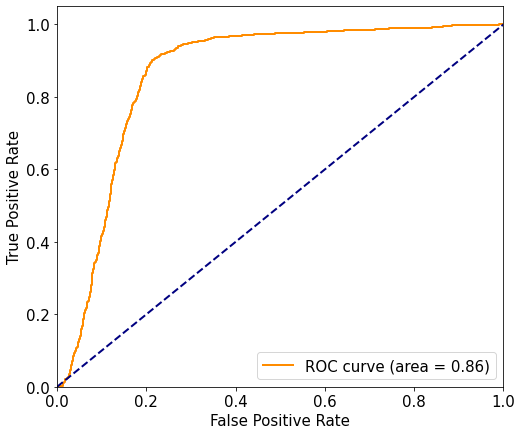

In [9]:
# Linear model Benchmark on centralized data using sk-learn:
#clf_linear = MLPClassifier(hidden_layer_sizes=(1,), max_iter=10000, shuffle=False, random_state=321).fit(x_train, y_train)
clf_linear = LogisticRegression(random_state=123).fit(x_train, y_train)
y_prediction = clf_linear.predict_proba(x_test)[:, 1]
plot_roc(y_test, y_prediction)

Now we run the federated experiment with `shfl`:

In [13]:
# Model builder can also be a list of models
from shfl.federated_government.vertical_federated_deep_learning import FederatedGovernmentVertical
from shfl.model.vertical_deep_learning_model import VerticalNeuralNetClient
from shfl.model.vertical_deep_learning_model import VerticalLogLinearServer
from shfl.private.federated_operation import ServerDataNode


class VerticalServerDataNode(ServerDataNode):
    """
        Aggregate weights from all data nodes in the server model and
        updates the server. In this vertical architecture, the server possesses part
        of the model, thus the aggregation is actually a server's training.
    """
    
    def aggregate_weights(self):
        
        embeddings = [data_node.query_model_params()
                      for data_node in self._federated_data]
        
        self.train_model(embeddings=embeddings)
        
    def compute_loss(self):
        """
        Evaluate loss on the train set.
        """
        embeddings = [data_node.query_model_params()
                      for data_node in self._federated_data]
        
        loss = self.query(model=self._model, embeddings=embeddings)
        
    def evaluate_collaborative_model(self, data_test, label_test):
        """
        Evaluation of the performance of the collaborative model.

        # Arguments:
            test_data: test dataset (global)
            test_label: corresponding labels to test dataset
        """

        # Compute embeddings (CLIENTS)
        embeddings = [data_node.predict(data_test[data_node_key])
                      for data_node, data_node_key in
                      zip(self._federated_data, data_test.keys())]

        # Compute prediction (SERVER)
        prediction = self.predict(embeddings)
        print("Distributed model test AUC: "
              + str(self.performance(prediction, label_test)))

        return prediction
        
        
# Assign a third node that acts as server:
# NOTE: how to assign the data to the server? 
# it should be done before actually configuring server's model. 
# POSSIBLE SOLUTION: maybe first create a FederatedNode (like we do for FederatedData),
# and later configure it's model, aggregator, and assign federated_data?
# This way, server's data would be secured. 
# Maybe we can use this solution: https://stackoverflow.com/questions/1216356/is-it-safe-to-replace-a-self-object-by-another-object-of-the-same-type-in-a-meth
server_node = VerticalServerDataNode(
        federated_data=federated_data, 
        model=VerticalLogLinearServer(), 
        aggregator=None,
        data=LabeledData(None, y_train))

model_nodes = [VerticalNeuralNetClient(n_features=x_train_client[0].shape[1]),
               VerticalNeuralNetClient(n_features=x_train_client[1].shape[1])]

federated_government = FederatedGovernmentVertical(model_nodes, 
                                                   federated_data, 
                                                   server_node=server_node)

In [14]:
from shfl.private.data import DataAccessDefinition

class ComputeLoss(DataAccessDefinition):
    def apply(self, data, **kwargs): 
        embeddings = kwargs.get("embeddings")
        model = kwargs.get("model")
        loss = model._compute_loss(
                embeddings, data.label)
        
        print("Collaborative model train loss: " + str(loss))
        
        return loss
    
server_node.configure_data_access(ComputeLoss())   
server_node._private_data_access_policies

{'140085555083360': <__main__.ComputeLoss at 0x7f678a291438>}

In [15]:
x_test_client_transpose = {i: x_test_client[i].T for i in range(len(x_test_client))}
federated_government.run_rounds(n=20001, 
                                test_data=x_test_client_transpose, 
                                test_label=y_test, 
                                print_freq=1000)

Round 0
Collaborative model train loss: 0.695437306687329
Distributed model test AUC: 0.5535971541404934


Round 1000
Collaborative model train loss: 0.6377580998756487
Distributed model test AUC: 0.7190251917098953


Round 2000
Collaborative model train loss: 0.597744297885202
Distributed model test AUC: 0.8050427897464728


Round 3000
Collaborative model train loss: 0.5692535694074261
Distributed model test AUC: 0.8362959170829406


Round 4000
Collaborative model train loss: 0.5483165084009671
Distributed model test AUC: 0.8482368382778422


Round 5000
Collaborative model train loss: 0.5324520689023736
Distributed model test AUC: 0.8536177473036521


Round 6000
Collaborative model train loss: 0.5201006261100392
Distributed model test AUC: 0.8564656527832573


Round 7000
Collaborative model train loss: 0.5102591207605739
Distributed model test AUC: 0.8581509118590378


Round 8000
Collaborative model train loss: 0.5022635205391455
Distributed model test AUC: 0.8591979163099186


Round 

Distributed model test AUC: 0.862475031345641


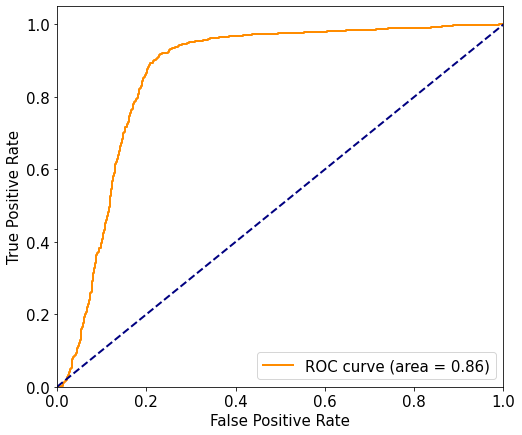

In [16]:
y_prediction = federated_government._server.evaluate_collaborative_model(
    data_test=x_test_client_transpose, label_test=y_test)
plot_roc(y_test, y_prediction)

## Non-linear model:
Analogously as before, we run the non-linear model on centralized data using `sk-learn`:

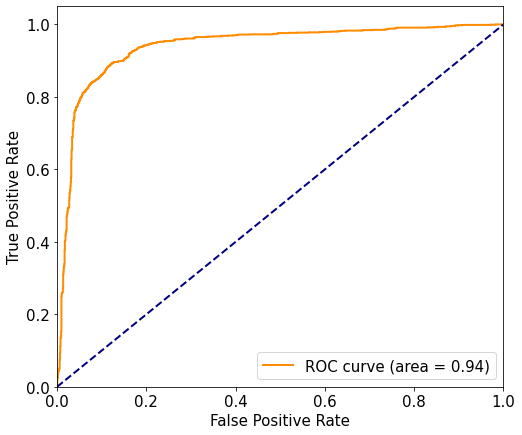

In [17]:
# Non-linear benchmark
clf_non_linear = MLPClassifier(hidden_layer_sizes=(3,), max_iter=10000, shuffle=False, random_state=3221).fit(x_train, y_train)
y_prediction = clf_non_linear.predict_proba(x_test)[:, 1]
plot_roc(y_test, y_prediction)

We run the federated experiment using non-linear deep neural network local model with `shfl`:

In [21]:
model_nodes = [VerticalNeuralNetClient(n_features=x_train_client[0].shape[1], 
                                       layer_dims=[3]),
               VerticalNeuralNetClient(n_features=x_train_client[1].shape[1], 
                                       layer_dims=[3])]

federated_government = FederatedGovernmentVertical(model_nodes, 
                                                   federated_data, 
                                                   server_node=server_node)

In [22]:
federated_government.run_rounds(n=100001, 
                                test_data=x_test_client_transpose, 
                                test_label=y_test, 
                                print_freq=10000)

Round 0
Collaborative model train loss: 0.9101311779000896
Distributed model test AUC: 0.47062227379655647




KeyboardInterrupt: 

Distributed model test AUC: 0.8641500605563535


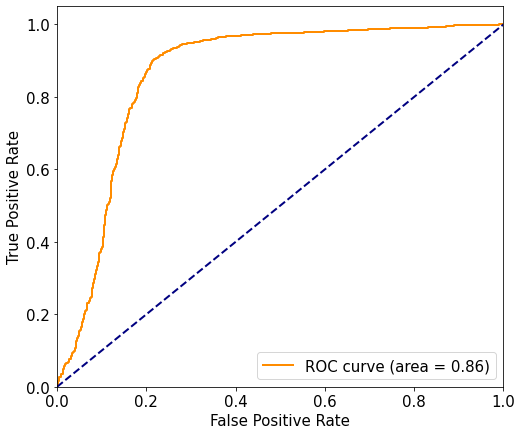

In [20]:
y_prediction = federated_government._server.evaluate_collaborative_model(
    data_test=x_test_client_transpose, label_test=y_test)
plot_roc(y_test, y_prediction)